# DCEGM Upper Envelope
## ["The endogenous grid method for discrete-continuous dynamic choice models with (or without) taste shocks"](https://onlinelibrary.wiley.com/doi/abs/10.3982/QE643)

<p style="text-align: center;"><small><small><small>For the following badges: GitHub does not allow click-through redirects; right-click to get the link, then paste into navigation bar</small></small></small></p>

[![Open in Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/econ-ark/DemARK/master?filepath=notebooks%2FDCEGM-Upper-Envelope.ipynb)

[![Open in CoLab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/econ-ark/DemARK/blob/master/notebooks/DCEGM-Upper-Envelope.ipynb)



This notebook provides a simple introduction to the upper envelope calculation in the "DCEGM" algorithm <cite data-cite="6202365/4F64GG8F"></cite>. It takes the EGM method proposed in <cite data-cite="6202365/HQ6H9JEI"></cite>, and extends it to the mixed choice (discrete and continuous) case. It handles various constraints. It works on a 1-dimensional problems.

The main challenge in the types of models considered in DCEGM is, that the first order conditions to the Bellman equations are no longer sufficient to find an optimum.  Though, they are still necessary in a broad class of models. This means that our EGM step will give us (resource, consumption) pairs that do fulfill the FOCs, but that are sub-optimal (there's another consumption choices for the same initial resources that gives a higher value).

Take a consumption model formulated as:
$$
\max_{\{c_t\}^T_{t=1}} \sum^T_{t=1}\beta^t\cdot u(c_t)
$$
given some initial condition on $x$ and some laws of motion for the states, though explicit references to states are omitted. Then, if we're in a class of models described in EGM
, we can show that
$$
c_t = {u_{c}}^{-1}[E_t(u_c(c_{t+1}))]
$$
uniquely determines an optimal consumption today given the expected marginal utility of consuming  tomorrow. However, if there is a another choice in the choice set, and that choice is discrete, we get
$$
\max_{\{c_t, d_t\}^T_{t=1}} \sum^T_{t=1}\beta^t\cdot u(c_t, d_t)
$$
again given initial conditions and the laws of motion. Then, we can show that
$$
c_t = {u_{c}}^{-1}[E_t(u_c(c_{t+1}))]
$$
will produce solutions that are necessary but not sufficient. Note, that there is no explicit mentioning of the discrete choices in the expectation, but they obviously vary over the realized states in general. For the optimal consumption, it doesn't matter what the choice is exactly, only what expected marginal utility is tomorrow. The algorithm presented in [1] is designed to take advantage of models with this structure.

To visualize the problem, consider the following pictures that show the output of an EGM step from the model in the REMARK [linkhere].

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# here for now, should be
# from HARK import discontools or whatever name is chosen
from HARK.interpolation import LinearInterp
from HARK.dcegm import calcSegments, calcMultilineEnvelope

In [3]:
m_common = np.linspace(0,1.0,100)
m_egm = np.array([0.0, 0.04, 0.25, 0.15, 0.1, 0.3, 0.6,0.5, 0.35, 0.6, 0.75,0.85])
c_egm = np.array([0.0, 0.03, 0.1, 0.07, 0.05, 0.36, 0.4, 0.6, 0.8, 0.9,0.9,0.9])
vt_egm = np.array( [0.0, 0.05, 0.1,0.04, 0.02,0.2, 0.7, 0.5, 0.2, 0.9, 1.0, 1.2])

Text(0, 0.5, 'transformed values')

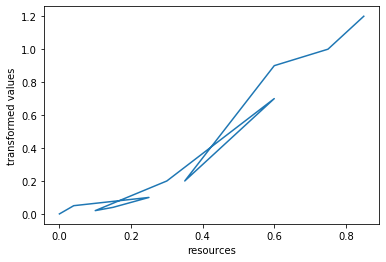

In [4]:
plt.plot(m_egm, vt_egm)
plt.xlabel("resources")
plt.ylabel("transformed values")

Text(0, 0.5, 'consumption')

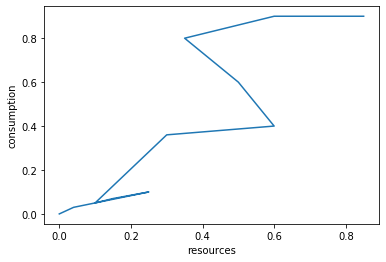

In [5]:
plt.plot(m_egm, c_egm)
plt.xlabel("resources")
plt.ylabel("consumption")

The point of DCEGM is to realize, that the segments on the `(m, vt)` curve that are decreasing, cannot be optimal. This leaves us with a set of increasing line segments, as seen below (`dcegmSegments` is the function in HARK that calculates the breaks where the curve goes from increasing to decreasing).

In [6]:
rise, fall = calcSegments(m_egm, vt_egm)

In `rise` we have all the starting indices for the segments that are "good", that is `(m, vt)` draws an increasing curve.

In [7]:
rise

array([0, 4, 8])

We see that `rise` has its first index at `0`, then again at `4`, and lastly at `8`. Let's look at `fall`.

In [8]:
fall

array([ 2,  6, 11])

We see that the last segment is increasing (as the last element of `rise` is larger than the last element of `fall`), and we see that `len(fall)` is one larger than number of problematic segments in the plot. The index of the last point in `m_egm`/`c_egm`/`vt_egm` is added for convenience when we do the upper envelope step (and is also convenient below for drawing the segments!).

We can use `fall` and `rise` to draw only the relevant segments that we will use to construct an upper envelope.

Text(0, 0.5, 'transformed values')

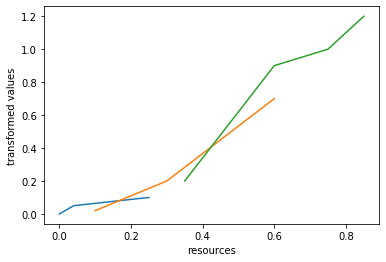

In [9]:
for j in range(len(fall)):
    idx = range(rise[j],fall[j]+1)
    plt.plot(m_egm[idx], vt_egm[idx])
plt.xlabel("resources")
plt.ylabel("transformed values")

Let us now use the `calcMultilineEnvelope` function to do the full DCEGM step: find segments and calculate upper envelope in one sweep.

In [10]:
m_upper, c_upper, v_upper = calcMultilineEnvelope(m_egm, c_egm, vt_egm, m_common)

Text(0, 0.5, 'transformed values')

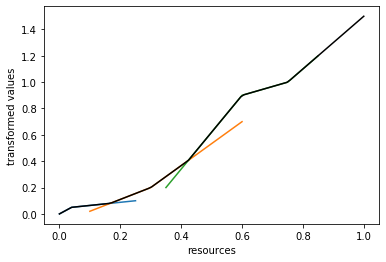

In [11]:
for j in range(len(fall)):
    idx = range(rise[j],fall[j]+1)
    plt.plot(m_egm[idx], vt_egm[idx])
plt.plot(m_upper, v_upper, 'k')
plt.xlabel("resources")
plt.ylabel("transformed values")

And there we have it! These functions are the building blocks for univariate discrete choice modeling in HARK, so hopefully this little demo helped better understand what goes on under the hood, or it was a help if you're extending some existing class with a discrete choice.

# AN EXAMPLE

In [16]:
# Params
y = 1
rra = 2
alpha = 0.1
tau = 0.2
beta = 0.9
aGrid = np.linspace(0,15,100)

# Function defs
def crra(x, rra):
    if rra == 1:
        return np.log(x)
    return x**(1-rra)/(1-rra)

def crraP(x, rra):
    return x**(-rra)

def crraPInv(x, rra):
    return x**(-1/rra)

u     = lambda x: crra(x,rra)
uP    = lambda x: crraP(x, rra)
uPinv = lambda x: crraPInv(x, rra)

# The last period

In [17]:
# Create a grid for market resources
mGrid = (aGrid-aGrid[0])*1.5

# Agent without a will
c3_grid_no = mGrid
v3_grid_no = u(c3_grid_no)

# Agent with a will

# Find the kink point
kink_m = uPinv(alpha)
inds_below = mGrid < kink_m
inds_above = mGrid > kink_m

c3_grid_wi = np.concatenate([mGrid[inds_below],
                             np.array([kink_m],
                             np.ones_like(mGrid[inds_above]*kink_m))])

C:\Users\Mateo\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in reciprocal
  del sys.path[0]


TypeError: data type not understood

# References
[1] Iskhakov, F. , Jørgensen, T. H., Rust, J. and Schjerning, B. (2017), The endogenous grid method for discrete‐continuous dynamic choice models with (or without) taste shocks. Quantitative Economics, 8: 317-365. doi:10.3982/QE643

[2] Carroll, C. D. (2006). The method of endogenous gridpoints for solving dynamic stochastic optimization problems. Economics letters, 91(3), 312-320.

